<center><h1 style:"text-align:center;">Formulación 1</h1></center>
<center><h3>Relé 1</h3></center>


### 1. Imports


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Métricas
from torchmetrics.functional.classification import binary_stat_scores

# Visualizar datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Progress bar
from tqdm import tqdm

# Acceder al sistema operativo
import os
import glob
import shutil
import random

### 2. Model Parameters


In [10]:
# LSTM parameters
hidden_dim = 20
n_signals = 3
N = 64

# _batch_size => m in figure 1.
train_batch_size = 64
dev_batch_size = 16
test_batch_size = 16

# Classification type (binary)
tagset_size = 1

# Set
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### 3. Model Creation


##### 3.1. FaultDetector Class Creation


In [11]:
# Model Creation


class FaultDetector(nn.Module):
    """Information about FaultDetector"""

    def __init__(self, n_signals, hidden_dim, tagset_size):
        super(FaultDetector, self).__init__()
        self.lstm = nn.LSTM(n_signals, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        # self.norm = nn.BatchNorm1d(tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])
        # norm_layer = self.norm(fc_layer)

        return torch.sigmoid(fc_layer)

##### 3.2. Model Instance Initialization


In [12]:
model = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Learning rate decay (optional)
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=decayRate
)

print(f"Model structure: {model}\n")

# Number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")

Model structure: FaultDetector(
  (lstm): LSTM(3, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Number of parameters: 2021


### 4. Dataset Creation


##### 4.1. Dataset Class Creation


In [171]:
import numpy as np
import pandas as pd
from itertools import repeat
import random
import utils_tesis.dataset_creator as dc
import matplotlib.pyplot as plt


class Form1Dataset(torch.utils.data.Dataset):
    """Some information about Form1Dataset"""

    def __init__(
        self,
        dataset_dir: str,
        signal_names: list[str],
        dataset_size: int = 999999,
        events_size: int = 999999,
    ):
        super(Form1Dataset, self).__init__()
        self.dataset_dir = dataset_dir
        self.signal_names = signal_names
        self.dataset_size = dataset_size
        self.events_size = events_size
        self.parquets = self.get_database_list()

        _signal = pd.read_parquet(f"{self.dataset_dir}/{self.parquets[0]}")
        self.time = _signal["time"]
        self.N = dc.cycle_info(_signal)["samples_per_cycle"]

        time_info = dc.extract_time_info(_signal, "time")
        self.time = self.calculate_time_array(time_info)

        self.max_window_idx = self.N - 1
        self.windows_event = dc.calculate_windows(_signal, self.N)
        # Reducir dataset size
        self.reduce_dataset()

    def calculate_time_array(self, time_info: dict) -> np.ndarray:
        dt = time_info["dt"]
        total_samples = time_info["total_samples"]
        total_time = time_info["total_time"]
        return np.linspace(0, total_time, total_samples)

    def __len__(self):
        return len(self.parquets) * self.windows_event

    def __getitem__(self, index):
        window_idx = index % self.max_window_idx
        parquet_idx = index // self.max_window_idx
        parquet_name = self.parquets[parquet_idx]
        parquet_path = f"{self.dataset_dir}/{parquet_name}"
        df = pd.read_parquet(parquet_path)[self.signal_names]

        df = df.iloc[window_idx : self.N + window_idx]
        if "F_T" in parquet_name:
            labels = np.array([1])
        if "L_T" in parquet_path:
            labels = np.array([0])
        signals = torch.from_numpy(df.to_numpy()).float()
        labels = torch.from_numpy(labels).float()
        return signals, labels

    def reduce_dataset(self):
        # reducir el tamaño de dataset, menos eventos
        if self.events_size < len(self.parquets):
            self.parquets = random.sample(self.parquets, self.events_size)
            self.dataset_size = len(self) * self.windows_event

        # reducir la cantidad de muestras (ventanas) según se necesite
        if self.dataset_size < len(self):
            self.parquets = random.sample(
                self.parquets, int(self.dataset_size / self.N)
            )

    def get_database_list(self):
        file_set = set()
        for dir_, _, files in os.walk(dataset_dir):
            for file_name in files:
                rel_dir = os.path.relpath(dir_, dataset_dir)
                rel_file = os.path.join(rel_dir, file_name)
                file_set.add(rel_file)
        parquets = list(file_set)

        return parquets

    def max_idx(self):
        return len(self.parquets) - 1

    def get_event(self, index):
        parquet_name = self.parquets[index]
        parquet_path = f"{self.dataset_dir}/{parquet_name}"
        if "F_T" in parquet_name:
            labels = np.array([1])
        if "L_T" in parquet_path:
            labels = np.array([0])
        return pd.read_parquet(parquet_path)[self.signal_names], labels

    def len_events(self):
        return len(self.parquets)

    def get_indices_event(self, index):
        min_idx = index * self.max_window_idx
        max_idx = min_idx + self.windows_event
        return np.arange(min_idx, max_idx)

    def get_time(self):
        return self.time

    def get_time_window(self, index):
        window_idx = index % self.max_window_idx
        return self.time[window_idx : self.N + window_idx]

    # def get_time_window(self, window_index):


from utils.relay_list import signals

dataset_dir = "D:\PaperLSTM\database\DB1_nueva_full\DB1_clean"
relay_number = 1
signal_names = signals[(relay_number - 1) * 3 : (relay_number - 1) * 3 + 3]
# signal_names.append("time")
dataset = Form1Dataset(
    dataset_dir,
    signal_names=signal_names,
)

##### 4.2. Database Directory Creation


##### 4.3. Dataset and Dataloader Instances Creation


In [14]:
from utils.relay_list import signals

dataset_dir = "D:\PaperLSTM\database\DB1_nueva_full\DB1_clean"
relay_number = 1
signal_names = signals[(relay_number - 1) * 3 : (relay_number - 1) * 3 + 3]


# signal_names.append("time")
dataset = Form1Dataset(
    dataset_dir,
    signal_names=signal_names,
)


# dataset.get_events(0)
windows_amount = len(dataset)
# CANTIDAD DESEADA TRAINING Y TESTING
windows_train = 5000
windows_test = 500
train_percentage = round(windows_train / windows_amount, 4)
test_percentage = round(windows_test / windows_amount, 4)
print(train_percentage, test_percentage)


train_dataset, test_dataset, _ = random_split(
    dataset, [train_percentage, test_percentage, 1 - train_percentage - test_percentage]
)


train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)


print(f"Cantidad de ventanas (train): {len(train_dataset):>4}")
print(f"Cantidad de ventanas (test): {len(test_dataset):>4}")

0.0051 0.0005
Cantidad de ventanas (train): 5020
Cantidad de ventanas (test):  493


### 5. Model Training


##### 5.1. Train / Test(dev) Loop Creation


In [15]:
# Create Training / Test / Validation Loops


# Training
def train(dataloader, model, loss_fn, optimizer, return_loss=False):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if return_loss == True:
            loss_list.append(loss.item())
        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")

        if batch % 5 == 0:
            my_lr_scheduler.step()
    if return_loss == True:
        return loss_list


from torchmetrics.functional.classification import binary_stat_scores


def test_metrics(dataloader, model, loss_fn, return_metrics=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    conf_matrix = torch.zeros(1, 5, dtype=torch.int64).to(device)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)

            conf_matrix = conf_matrix.add(binary_stat_scores(pred, y))
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    acc = (conf_matrix[0, 0] + conf_matrix[0, 2]) / conf_matrix[0, :-1].sum()
    correct /= size
    print(f"{correct*100:>0.1f}")
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if return_metrics == True:
        return conf_matrix, test_loss

##### 5.2. Training the model


In [17]:
# model.load_state_dict(torch.load("models\R2.pth"))
# model.load_state_dict(torch.load("./models/LSTMHarmonic_weights_R1_996.pth"))
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R2_978.pth'))
# model.load_state_dict(torch.load('./models/R2Currents_DB2.pth'))
epochs = 1

for epoch in range(epochs):

    print(f"Epoch {epoch+1}\n--------------------------------")
    # train_loss = train(train_dataloader, model, loss_fn, optimizer, return_loss=True)
    conf_matrix, _ = test_metrics(test_dataloader, model, loss_fn, return_metrics=True)
print(conf_matrix)

Epoch 1
--------------------------------


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]

95.5
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.241501 

tensor([[217,   0, 254,  22, 239]])


In [18]:
def conf_matrix_metrics(conf_matrix: torch.LongTensor) -> dict:
    """
    Returns dictionary with metrics from a confusion matrix.


            Parameters:
                    conf_matrix (torch.Tensor): confusion matrix of dimension (1, 5)
                        [TP, FP, TN, FN, TP + FN]

            Returns:
                    metrics (dict): dictionary with following metrics:
                        metrics["TOTAL"] -> total amount of samples.
                        metrics["TPR"]   -> True Positive Rate,  sensibility, recall, hit-rate.
                        metrics["FPR"]   -> False Positive Rate, Fallout.
                        metrics["TNR"]   -> True Negative Rate,  specificity, selectivity
                        metrics["ACC"]   -> Accuracy.
                        metrics["PPV"]   -> Positive Predictive Value, Precision.
    """
    if conf_matrix.shape == (5,):
        conf_matrix = np.expand_dims(conf_matrix, axis=0)

    metrics = {}
    TP = int(conf_matrix[0, 0].item())
    FP = int(conf_matrix[0, 1].item())
    TN = int(conf_matrix[0, 2].item())
    FN = int(conf_matrix[0, 3].item())
    metrics["TP"] = TP
    metrics["FP"] = FP
    metrics["TN"] = TN
    metrics["FN"] = FN
    P = TP + FN
    N = TN + FP
    TOTAL = TP + FP + TN + FN
    metrics["TOTAL"] = TOTAL
    try:
        metrics["TPR"] = TP / (TP + FN)
    except ZeroDivisionError:
        metrics["TPR"] = "ZeroDivisionError"
    try:
        metrics["FPR"] = FP / (FP + TN)
        metrics["TNR"] = TN / (FP + TN)
    except ZeroDivisionError:
        metrics["FPR"] = "ZeroDivisionError"
        metrics["TNR"] = "ZeroDivisionError"
    metrics["ACC"] = (TP + TN) / (TOTAL)
    try:
        metrics["PPV"] = TP / (TP + FP)
    except ZeroDivisionError:
        print("No se puede obtener PPV, división por cero")
    return metrics


metrics = conf_matrix_metrics(conf_matrix)
print(round(metrics["ACC"] * 100, 1))
print(conf_matrix)

95.5
tensor([[217,   0, 254,  22, 239]])


##### 5.3. Training loss visualization


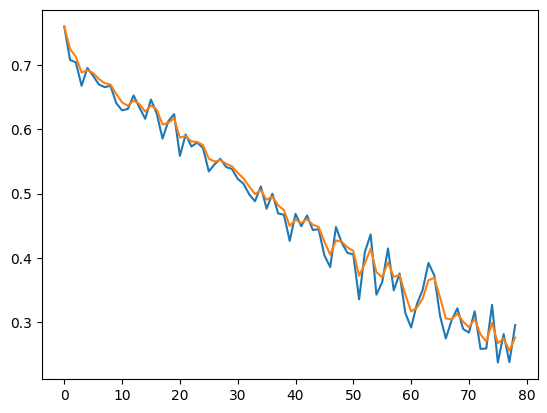

In [19]:
try:
    mini_batch_list = [index for index, _ in enumerate(train_loss)]
    train_loss_ewm = pd.DataFrame(train_loss).ewm(com=0.95).mean()
    plt.plot(mini_batch_list, train_loss, mini_batch_list, train_loss_ewm)
except NameError:
    print("Error! Run train loop")

##### 5.4. Saving the Model


In [20]:
# # Save the Model
# model.load_state_dict(torch.load('./models/R3Currents_DB2_V2.pth'))
torch.save(model.state_dict(), f"./models/paper_jan/{relay_number}_Currents.pth")

### 6. Results Visualization


#### 6.1. Confussion Matrix Results Table Function


In [21]:
# Data visualization (CPU)


def confusion_matrix_labels(pred_label, true_label):
    label = ""
    if int(pred_label) == int(true_label):
        label += "T"
    else:
        label += "F"
    if pred_label == 1:
        label += "P"
    else:
        label += "N"
    return label


confusion_matrix_pandas = np.vectorize(confusion_matrix_labels)


def confusion_matrix(
    preds: torch.FloatTensor, labels: torch.FloatTensor
) -> pd.DataFrame:
    preds = preds.detach()
    labels = labels.detach()
    data = {
        "Pred probability": torch.reshape(preds, (-1,)).cpu().numpy(),
        "Pred label": torch.reshape(torch.round(preds), (-1,)).int().cpu().numpy(),
        "True label": torch.reshape(labels, (-1,)).int().cpu().numpy(),
    }
    df = pd.DataFrame(data)
    df["Result"] = confusion_matrix_pandas(df["Pred label"], df["True label"])
    return df

##### 6.2. Plotly Plot


In [22]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fs = 960
dataset_plot = Form1Dataset(
    dataset_dir,
    signal_names=signal_names,
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signals, labels = next(dataiter)
print(signals.shape)


x = model(signals[0:9].to(device))
# x = x.detach()

# Crear Matriz de confusión
df = confusion_matrix(x, labels[0:9])
print(type(df))
print(df)

# figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
fig = make_subplots(rows=rows, cols=cols)

label_to_text = {
    "0": "No Fault",
    "1": "Fault",
}

for i in range(0, cols * rows):

    col = i % cols
    row = i // cols
    label = label_to_text[str(int(labels[i, 0].item()))]
    # win_idx = str(window_idx[i].item())
    # print(csv_name[i])
    fig.add_trace(
        go.Scatter(
            # name=f"{label} - {win_idx} - {csv_name[i]}",
            name=f"{label}",
            y=signals[i, :, 0],
            # y=signals[i, :, 1],
            marker_color="black",
        ),
        row=row + 1,
        col=col + 1,
    )

fig.update_layout(
    height=700,
    width=900,
    title_text="Figuras",
    margin={"b": 20, "t": 40, "l": 20, "r": 30},
    plot_bgcolor="rgba(0,0,0,0)",
    # paper_bgcolor="whitesmoke",
)
fig.show()

torch.Size([64, 64, 3])
<class 'pandas.core.frame.DataFrame'>
   Pred probability  Pred label  True label Result
0          0.141476           0           0     TN
1          0.313484           0           0     TN
2          0.733948           1           1     TP
3          0.619360           1           1     TP
4          0.948524           1           1     TP
5          0.139046           0           0     TN
6          0.469107           0           1     FN
7          0.935549           1           1     TP
8          0.787573           1           1     TP


##### 6.3. Matplotlib Plots


   Pred probability  Pred label  True label Result
0          0.919458           1           1     TP
1          0.303686           0           0     TN
2          0.655291           1           1     TP
3          0.915611           1           1     TP
4          0.161651           0           0     TN
5          0.740767           1           1     TP
6          0.920892           1           1     TP
7          0.894097           1           1     TP
8          0.138606           0           0     TN


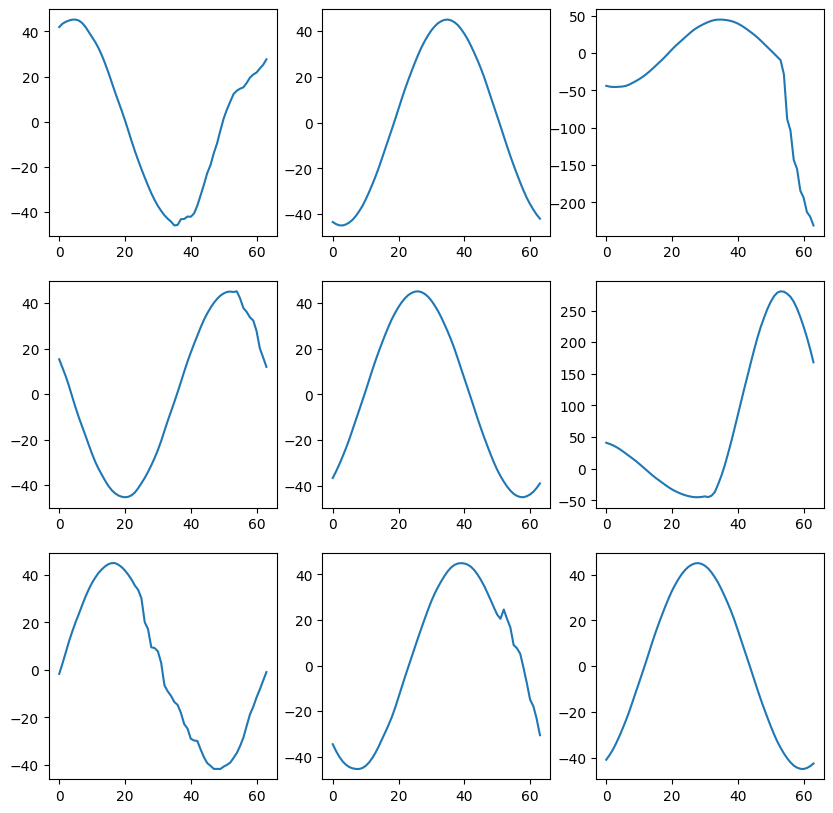

In [24]:
dataset_plot = Form1Dataset(
    dataset_dir,
    signal_names=signal_names,
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, labels = next(dataiter)
fs = 960

x = model(signal_windows[1:10].to(device))
x = x.detach()

# Crear Matriz de confusión
df = confusion_matrix(x, labels[1:10])
print(df)

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(signal_windows[i, :, 0])

### 7. Data Exploration


##### 7.1. Auxiliar Functions


In [167]:
def signal_exploration(event_idx, dataset: Form1Dataset, model, plot: bool = False):
    window_indices = dataset.get_indices_event(event_idx)
    conf_matrix = torch.zeros(1, 5, dtype=torch.int64).to(device)
    preds = torch.empty((0, 1)).to(device)
    labels = torch.empty((0, 1)).to(device)
    # plot signal
    if plot:
        signals, label = dataset.get_event(event_idx)
        t = dataset.get_time()
        plt.plot(t, signals)
        plt.show()

    for idx in window_indices:
        signal, label = dataset[idx]
        label = torch.unsqueeze(label, 0).to(device)
        signal = torch.unsqueeze(signal, 0).to(device)
        pred = model(signal)
        preds = torch.cat((preds, pred), 0)
        labels = torch.cat((labels, label), 0)
        conf_matrix = conf_matrix.add(binary_stat_scores(pred, label))
    df = confusion_matrix(preds, labels)
    max_idx, min_idx = window_indices[-1], window_indices[0]
    df.insert(
        loc=0, column="event_idx", value=np.repeat(event_idx, max_idx - min_idx + 1)
    )
    return df, conf_matrix


def plot_confusion_matrix(metrics):
    z = [[metrics["TP"], metrics["FN"]], [metrics["FP"], metrics["TN"]]]
    fig = px.imshow(
        z,
        text_auto=True,
        template="seaborn",
        labels=dict(x="Predicted Label", y="Real Label", color="Predictions"),
        x=["Positive", "Negative"],
        y=["Positive", "Negative"],
        width=400,
        height=300,
    )
    fig.show()


def print_metrics(metrics):
    print(f"{'Total windows:':.<30}{metrics['TOTAL']:4}")
    print(f"{'True Positives:':.<30}{metrics['TP']:4}")
    print(f"{'False Positives:':.<30}{metrics['FP']:4}")
    print(f"{'True Negatives:':.<30}{metrics['TN']:4}")
    print(f"{'False Negatives:':.<30}{metrics['FN']:4}")
    print(f"{'Accuracy:':.<30}{metrics['ACC']*100:>6.1f}%")
    try:
        print(f"{'True Positive Rate:':.<30}{metrics['TPR']*100:>6.1f}%")
    except ValueError:
        print("TPR cannot be calculates, division by zero")
    try:
        print(f"{'False Positive Rate:':.<30}{metrics['FPR']*100:>6.1f}%")
        print(f"{'True Negative Rate:':.<30}{metrics['TNR']*100:>6.1f}%")
    except ValueError:
        print("FPR and TNR cannot be calculates, division by zero")

    try:
        print(f"{'Positive Predictive Value:':.<30}{metrics['PPV']*100:>6.1f}%")
    except KeyError:
        print(f"PPV divided by 0. No positive class predicted")
    # metrics["PPV"]

##### 7.2. Data Exploration


##### 7.4. Plot individual windows


##### 7.5. Whole Dataset Exploration


In [98]:
# model.load_state_dict(torch.load("./models/R2.pth"))

In [177]:
# Create Dataframe with information about data
dataset = Form1Dataset(dataset_dir, signal_names=signal_names, events_size=10)
print(len(dataset.get_time()))
print(len(dataset.get_time_window(0)))


df, conf_matrix = signal_exploration(1, dataset, model)
metrics = conf_matrix_metrics(conf_matrix)
# plot_confusion_matrix(metrics)
# print(df)
# print(conf_matrix)
print(metrics)


conf_matrix = torch.zeros(0, 5, dtype=torch.int64).to(device)
for idx in tqdm(range(dataset.len_events())):
    # for idx in tqdm(range()):
    df, CM = signal_exploration(idx, dataset, model)
    conf_matrix = torch.cat((conf_matrix, CM))
    if idx == 0:
        dataset_df = df

    else:
        dataset_df = pd.concat([dataset_df, df])

dataset_df = dataset_df.reset_index()



dataset_df = dataset_df.rename(columns={"index": "window idx"})
conf_matrix_total = np.sum(conf_matrix.cpu().numpy(), axis=0)



# # Load Dataframe
# def load_df(i):



#     dataset_df = pd.read_parquet(f"parquet_data/R{i}_df.parquet")
#     conf_matrix_df = pd.read_parquet(f"parquet_data/R{i}_CM_df.parquet")
#     conf_matrix = np.load(f"parquet_data/R{i}_CM.npy", allow_pickle=False)
#     return dataset_df, conf_matrix_df, conf_matrix



# dataset_df, conf_matrix_df, conf_matrix = load_df(1)



# dataset_df = pd.read_parquet(f"parquet_data\R2_currents_DB2_df.parquet")
# conf_matrix_df = pd.read_parquet(f"parquet_data\R2_currents_DB2_CM_df.parquet")
# conf_matrix = np.load(f"parquet_data\R2_currents_DB2_CM.npy", allow_pickle=False)
# conf_matrix_total = np.sum(conf_matrix, axis=0)



# conf_matrix_total = np.sum(conf_matrix, axis=0)
# metrics = conf_matrix_metrics(conf_matrix_total)

126
64
{'TP': 54, 'FP': 0, 'TN': 0, 'FN': 9, 'TOTAL': 63, 'TPR': 0.8571428571428571, 'FPR': 'ZeroDivisionError', 'TNR': 'ZeroDivisionError', 'ACC': 0.8571428571428571, 'PPV': 1.0}


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


In [182]:
print(conf_matrix_total)
print(conf_matrix)
conf_matrix_total = np.sum(conf_matrix.cpu().numpy(), axis=0)
metrics = conf_matrix_metrics(conf_matrix_total)
print_metrics(metrics)
print(dataset_df.to_string())

[291   0 315  24 315]
tensor([[ 0,  0, 63,  0,  0],
        [54,  0,  0,  9, 63],
        [ 0,  0, 63,  0,  0],
        [ 0,  0, 63,  0,  0],
        [62,  0,  0,  1, 63],
        [62,  0,  0,  1, 63],
        [60,  0,  0,  3, 63],
        [ 0,  0, 63,  0,  0],
        [53,  0,  0, 10, 63],
        [ 0,  0, 63,  0,  0]])
Total windows:................ 630
True Positives:............... 291
False Positives:..............   0
True Negatives:............... 315
False Negatives:..............  24
Accuracy:.....................  96.2%
True Positive Rate:...........  92.4%
False Positive Rate:..........   0.0%
True Negative Rate:........... 100.0%
Positive Predictive Value:.... 100.0%
     window idx  event_idx  Pred probability  Pred label  True label Result
0             0          0          0.177547           0           0     TN
1             1          0          0.179726           0           0     TN
2             2          0          0.181467           0           0     TN
3       

In [100]:
# df and plots settings
pd.set_option("display.float_format", "{:.2%}".format)

pd.options.plotting.backend = "matplotlib"


# print(dataset_df)
pd.set_option("display.max_rows", 2000)
false_positive = dataset_df.query('Result == "FP"')
false_negative = dataset_df.query('Result == "FN"')
# sample_df = pd.concat([sample_df, sample_df])

false_positive_plot = false_positive.groupby(["window idx"])["window idx"].count()
false_negative_plot = false_negative.groupby(["window idx"])["window idx"].count()
# print(false_positive['Pred probability'].value_counts(bins=10, sort=False))


if len(false_positive_plot) > 0:
    print("FALSE POSITVES")
    print(false_positive)
    # print(false_positive.groupby(['event_idx'])['event_idx'].count())
    false_positive.groupby(["event_idx"])["event_idx"].count().plot(kind="bar")
    plt.show()
    false_positive_plot.plot(kind="bar", edgecolor="black")
    plt.show()
    false_positive["Pred probability"].value_counts(
        bins=[i * 0.1 for i in range(5, 11)], sort=False, normalize=True
    ).plot(kind="bar")
    plt.show()
if len(false_negative_plot) > 0:
    print("FALSE NEGATIVES")
    print(false_negative)
    # print(false_negative.groupby(['event_idx'])['event_idx'].count())
    false_negative.groupby(["event_idx"])["event_idx"].count().plot(kind="bar")
    plt.show()

    false_negative_plot.plot(kind="bar", edgecolor="black")
    plt.show()
    false_negative["Pred probability"].value_counts(
        bins=[i * 0.1 for i in range(6)], sort=False, normalize=True
    ).plot(kind="bar")
    plt.show()

plt.show()

In [ ]:
# model.load_state_dict(torch.load('models\LSTMHarmonic_weights_R3Currents.pth'))
print(conf_matrix_total)
metrics = conf_matrix_metrics(conf_matrix_total)
print_metrics(metrics)
plot_confusion_matrix(metrics)

##### 7.6. Save Dataframe and Confusion Matrix


In [180]:
dataset_df.to_parquet(f"parquet_data/paper_jan/R{relay_number}_df.parquet")
conf_matrix_df = pd.DataFrame(
    conf_matrix.cpu(), columns=["TP", "FP", "TF", "FN", "TP + FN"]
)
conf_matrix_df.to_parquet(f"parquet_data/paper_jan/R{relay_number}_CM_df.parquet")
np.save(f"parquet_data/paper_jan/R{relay_number}_CM.npy", conf_matrix.cpu())

##### 7.7. Individual Sample Visualization


In [ ]:
# Create signal_df
event_idx = 9
print(dataset.csv_list[event_idx])
sample_df, conf_matrix = signal_exploration(event_idx, dataset, model)
metrics = conf_matrix_metrics(conf_matrix)
print(f"Confusion Matrix: {conf_matrix}")
print(sample_df)
plot_confusion_matrix(metrics)
false_positive = sample_df.query('Result == "FP"')
false_negative = sample_df.query('Result == "FN"')
# sample_df = pd.concat([sample_df, sample_df])
print("FALSE POSITVES")
print(false_positive)
print("")
print("FALSE NEGATIVES")
print(false_negative)

In [ ]:
window_idx = 56
sample_idx = (max_window_idx * event_idx) + window_idx


def update_fig(fig):
    fig.update_traces(line_color="#EEEEEE", line_width=2)
    fig.update_layout(
        paper_bgcolor="#222831",
        plot_bgcolor="#393E46",
        font_color="whitesmoke",
    )
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="#32E0C4")
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="#32E0C4")


signal, t = dataset.__getitem__(sample_idx, data_plot=True)
signal = np.copy(signal)
signal = signal.reshape((-1, 3))
signal = signal[:, 0]
t = np.copy(t)
print(type(t))
print(type(signal))
# print(f"Window index: {sample_df.query('indices == 196').index[0]}")
fig = px.line(
    x=t,
    y=signal,
    width=600,
    height=400,
    labels=dict(x="time", y="Amplitude"),
)
# update_fig(fig)x
fig.show()
fig = px.line(
    x=sample_df.index,
    y=sample_df["Pred label"],
    width=600,
    height=400,
    labels=dict(x="Window", y="Trip Signal"),
    line_shape="hv",
)
# update_fig(fig)
fig.show()

In [62]:
import csv

with open("./dataset_lists/R2_list.csv", "w") as f:
    write = csv.writer(f)
    write.writerow(dataset.csv_list)

#### Por hacer

- Colocar tiempo en la gráfica de disparo


### 8. References

1. PyTorch Contributors: LSTM. [LSTM — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
<!-- @online{LSTM,
    author = "{PyTorch Contributors}",
    title = "LSTM",
    url  = "https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html",
    addendum = "(accessed: 10.02.2023)",
    keywords = "LSTM pytorch"
} -->
